In [1]:
import torch
import pyro

In [2]:
m = 0
s = 1
normal = torch.distributions.Normal(m, s)
x = normal.rsample()
print('sample', x)
print('log prob', normal.log_prob(x))

sample tensor(-1.3357)
log prob tensor(-1.8110)


In [3]:
def weather():
    cloudy = pyro.distributions.Bernoulli(0.3).sample()
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.distributions.Normal(mean_temp, scale_temp).rsample()
    return cloudy, temp.item()

In [4]:
weather()

('sunny', 97.01063537597656)

In [5]:
cloudy_pdf = pyro.distributions.Bernoulli(0.3)

def temp_pdf(is_cloudy):
  m, s = (55.0, 10.0) if is_cloudy else (75.0, 15.0)
  return pyro.distributions.Normal(m, s)

def cloudy_str(is_cloudy):
  return 'cloudy' if is_cloudy else 'sunny'

def weather():
  cloudy = pyro.sample('cloudy', cloudy_pdf)
  is_cloudy = cloudy.item() == 1.0
  temp = pyro.sample('temp', temp_pdf(is_cloudy))
  return is_cloudy, temp.item()

for _ in range(3):
  is_cloudy, temp = weather()
  print((cloudy_str(is_cloudy), temp))

('sunny', 43.183597564697266)
('cloudy', 55.55808639526367)
('sunny', 103.19703674316406)


In [6]:
def ice_cream_pdf(is_cloudy, temp):
  m = 200.0 if not is_cloudy and temp > 80.0 else 50.0
  return pyro.distributions.Normal(m, 10.0)

def ice_cream_sales():
  return pyro.sample('ice_cream', ice_cream_pdf(*weather()))

for _ in range(10):
  print(ice_cream_sales().item())

62.67461013793945
64.92877960205078
67.72350311279297
54.39554214477539
204.452880859375
33.4540901184082
52.21428298950195
54.8080940246582
201.04031372070312
55.73650360107422


In [7]:
def geometric(p, t=None):
  if t is None:
    t = 0
  x = pyro.sample(f'x_{t}', pyro.distributions.Bernoulli(p))
  if x.item() == 1:
    return 0
  else:
    return 1 + geometric(p, t+1)

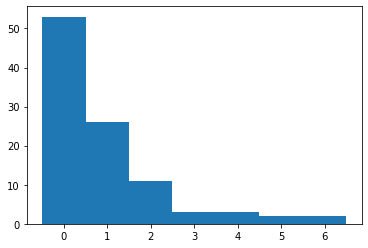

In [28]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

c = Counter(geometric(0.5) for _ in range(100))
labels, vals = zip(*sorted(c.items()))

width = 1
inds = np.arange(len(labels))
plt.bar(inds, vals, width)
plt.xticks(inds, labels)
plt.show()

In [29]:
def normal_product(m, s):
  n = pyro.distributions.Normal(m, s)
  z1 = pyro.sample('z1', n)
  z2 = pyro.sample('z2', n)
  return z1 * z2

def make_normal_normal():
  n = pyro.distributions.Normal(0,1)
  mu_latent = pyro.sample('mu_latent', n)
  return lambda s: normal_product(mu_latent, s)

print(make_normal_normal()(1.0))

tensor(-0.3078)


In [30]:
import pyro.infer
import pyro.optim
import pyro.distributions as dist

In [31]:
def scale(guess):
  weight = pyro.sample('weight', dist.Normal(guess, 1.0))
  return pyro.sample('measurement', dist.Normal(weight, 0.75))

for _ in range(4):
  print(scale(10))

tensor(11.7514)
tensor(10.8844)
tensor(10.3078)
tensor(9.4212)


In [32]:
cond_scale = pyro.condition(scale, data={'measurement': 9.5})

In [33]:
def deferred_cond_scale(measurement, guess):
  return pyro.condition(scale, data={'measurement': measurement})(guess)

In [51]:
deferred_cond_scale(9.5, 10)

9.5